### Segmentation 01 (2D)

In [1]:
%run ../utils.py
%run models.py
import os
import os.path as osp
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvutils import visualize
from cytokit import io as cytokit_io
from cytokit import config as cytokit_config
from skimage import feature
from skimage import filters
from skimage import measure
from skimage import segmentation
from skimage import morphology
from skimage import draw
from skimage import exposure
from scipy import ndimage

plt.gray()
init_session()

# exp_name = '20180611_D18_PMBC_500G'
# exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'config')
# exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'output', 'nodeconv')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 0
# mem_ch = 2
# best_z = 21
# #crop = [slice(0, 512), slice(0, 512)]
# crop = [slice(None, None), slice(None, None)]

exp_name = '7-7-17-multicycle'
exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle')
exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
nuc_cyc = 0
nuc_ch = 0
mem_cyc = 2
mem_ch = 1
best_z = 4
crop = [slice(0, 512), slice(0, 512)]
#crop = [slice(None, None), slice(None, None)]

model_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.1')
model_path = osp.join(model_dir, 'nuclei_model.h5')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
exp_conf = cytokit_config.load(exp_conf_dir)

In [3]:
tile = cytokit_io.read_tile(osp.join(exp_data_dir, 'reg001_X01_Y01.tif'), exp_conf)
tile = tile[:, :, :, crop[0], crop[1]]
tile.shape, tile.dtype

((8, 9, 4, 512, 512), dtype('uint16'))

In [4]:
if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

In [5]:
exp_conf.channel_names

['HOECHST1',
 'CollagenIV',
 'CD7',
 'Ki67',
 'HOECHST2',
 'CD38',
 'CD31',
 'CD4',
 'HOECHST3',
 'CD45',
 'CD90',
 'CD19',
 'HOECHST4',
 'CD15',
 'CD3',
 'CD104',
 'HOECHST5',
 'CD21',
 'CD34',
 'CD278',
 'HOECHST6',
 'HLADR',
 'CD22',
 'CD279',
 'HOECST7',
 'CD8',
 'CD40',
 'cytokeratin',
 'HOECHST8',
 'CD9',
 'Podoplanin',
 'CD11c']

In [6]:
# img_nuc = tile[nuc_cyc, best_z, nuc_ch]
# visualize.display_images([filters.rank.median(img_nuc, morphology.square(3))], size=50)

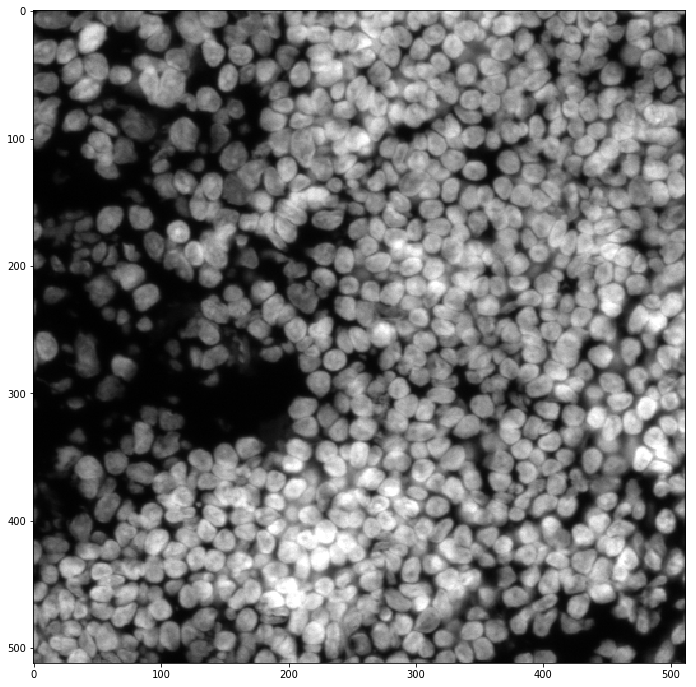

In [7]:
img_nuc = tile[nuc_cyc, best_z, nuc_ch]
#filters.rank.median(img_nuc, morphology.square(3))
plt.imshow(img_nuc)
plt.gcf().set_size_inches(12, 12)

In [8]:
%run models.py
moments = {'mean': 22.95665170512068, 'std': 39.01833230843019}
input_shape = img_nuc.shape + (1,)
opt_conv = {"activation": "elu", "padding": "same", 'kernel_initializer': 'he_normal'}
model = get_model(3, input_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=True, dropout=None, opt_conv=opt_conv)

In [9]:
model.load_weights(model_path)

In [10]:
#model = keras.models.load_model(model_path, compile=False)

In [13]:
img_pred = model.predict(np.expand_dims(np.expand_dims((img_nuc.astype(np.float32) - moments['mean'])/moments['std'], 0), -1))
img_pred.shape

(1, 512, 512, 3)

In [14]:
def get_pred_img_overlay(img_pred, chs=[0, 1, 2]):
    return np.stack([
        exposure.rescale_intensity(img_pred[0][..., yi], out_range=np.uint8).astype(np.uint8)
        for yi in chs
    ], -1)

In [15]:
#img_pred_overlay = get_pred_img_overlay(img_pred, chs=[0])[..., 0]
img_pred_overlay = get_pred_img_overlay(img_pred, chs=[0,1,2])
#img_pred_overlay = get_pred_img_overlay(img_pred, chs=[0,2,0])

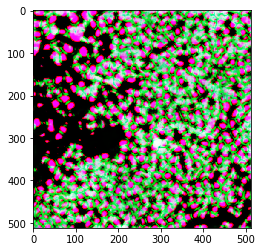

In [16]:
from skimage import img_as_float
plt.imshow(img_as_float(img_pred_overlay))
#plt.imshow(img_as_float(img_nuc))
#plt.gcf().set_size_inches(24, 24)

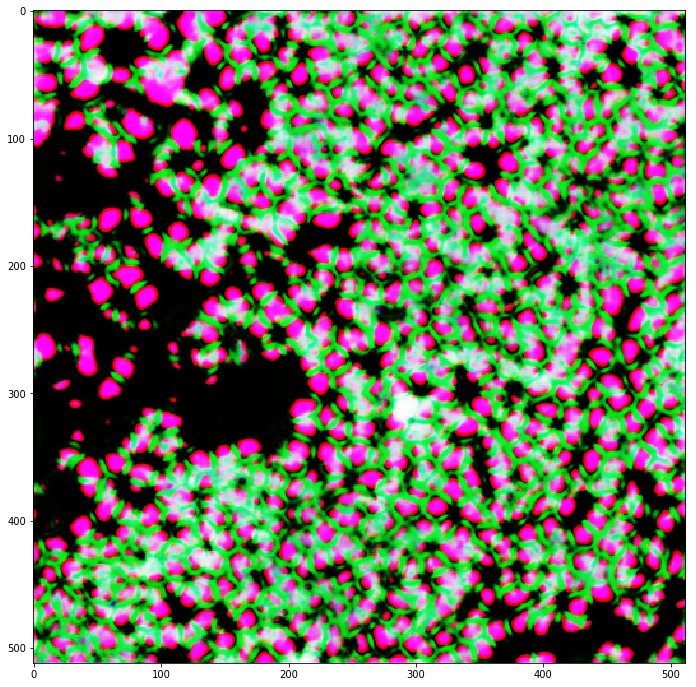

In [17]:
from skimage import color
from skimage import exposure
blend_img = 0.0 * img_as_float(color.gray2rgb(img_nuc)) + \
    1. * img_as_float(color.gray2rgb(img_pred_overlay))
plt.imshow(blend_img)
plt.gcf().set_size_inches(12, 12)

In [18]:
# def prepocess(img, thresh, dilation_factor=1, erosion_factor=1):
#     img = img > thresh
#     img = morphology.dilation(img, selem=morphology.diamond(dilation_factor))
#     img = morphology.erosion(img, selem=morphology.diamond(erosion_factor))
#     img = morphology.remove_small_holes(img, area_threshold=4)
#     img = morphology.remove_small_objects(img, min_size=16)
#     return img

def prepocess(img, thresh, dilation_factor=1, erosion_factor=1):
    img = img > thresh
    img = morphology.remove_small_holes(img, area_threshold=6)
    img = morphology.erosion(img, selem=morphology.diamond(erosion_factor))
    img = morphology.remove_small_objects(img, min_size=8)
    return img

In [19]:
img_bin_nuci = prepocess(img_pred[0, ..., 0], .6)
img_bin_nucb = prepocess(img_pred[0, ..., 1], .6)
img_bin_nucm = prepocess(img_pred[0, ..., 2], .6)

img_bin_nucm = img_bin_nucm & img_bin_nuci & ~img_bin_nucb

In [20]:
# imgt = img_bin_nuci[:250, :250]
# visualize.display_images([imgt, morphology.thin(imgt), morphology.skeletonize(imgt), morphology.erosion(imgt, morphology.disk(4))], cols=3, size=30)

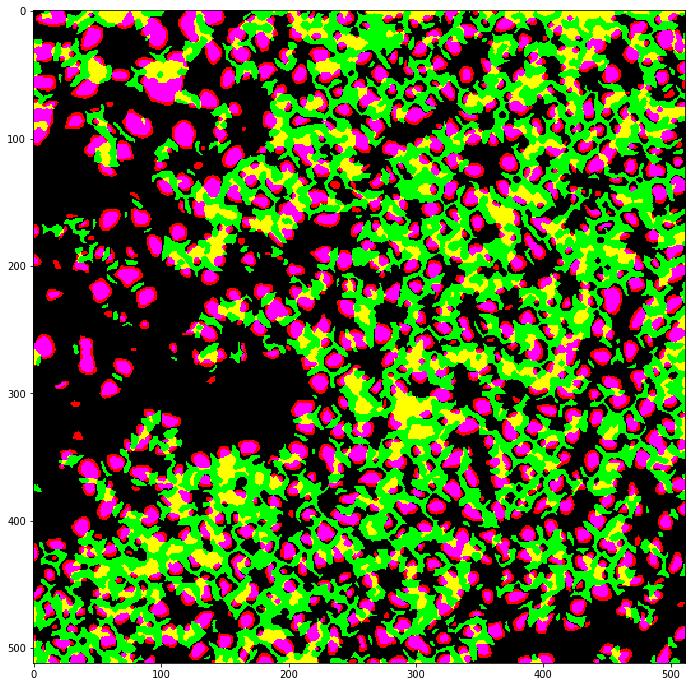

In [21]:
plt.imshow(np.stack([img_bin_nuci, img_bin_nucb, img_bin_nucm], axis=-1).astype(float))
plt.gcf().set_size_inches(12, 12)

In [22]:
img_bin_nucm_label = morphology.label(img_bin_nucm)
img_bin_nuci_basin = ndimage.distance_transform_edt(img_bin_nuci)
img_bin_nucb_basin = ndimage.distance_transform_edt(img_bin_nucb)
img_basin = -img_bin_nuci_basin + img_bin_nucb_basin

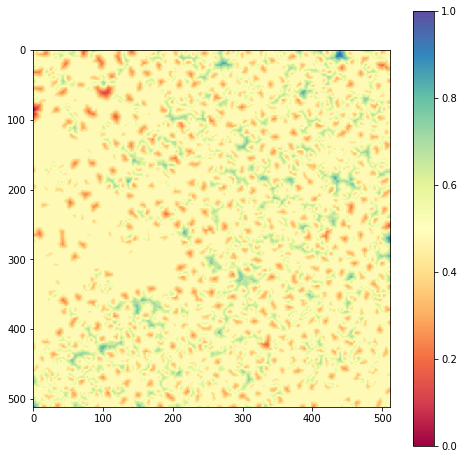

In [23]:
plt.imshow(exposure.rescale_intensity(img_basin, out_range=(0, 1)), cmap='Spectral')
plt.gcf().set_size_inches(8, 8)
plt.colorbar()

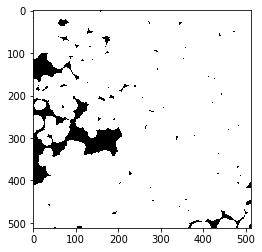

In [24]:
def get_segmentation_mask(img_bin_nuci, img_bin_memb=None, dilation_factor=0):
    if img_bin_memb is None:
        if dilation_factor <= 0:
            return img_bin_nuci
        else:
            return morphology.dilation(img_bin_nuci, selem=morphology.disk(dilation_factor))
    else:
        raise NotImplementedError()
        
seg_mask = get_segmentation_mask(img_bin_nuci, dilation_factor=8)
plt.imshow(seg_mask)

### Run Segmentation

In [25]:
img_seg = segmentation.watershed(img_basin, img_bin_nucm_label, mask=seg_mask)

In [26]:
img_border = segmentation.find_boundaries(img_seg, mode='inner', background=img_seg.min())

In [29]:
img_seg_border = img_seg.copy()
img_seg_border[img_border > 0] = -20
#img_seg_border[img_com > 0] = -30

img_nuc_border = img_nuc.copy()
#img_nuc_border[img_bin_nucb > 0] = -50
img_nuc_border[img_bin_nucm > 0] = -20
img_nuc_border[img_border > 0] = -1

# img_mem_border = img_mem.copy()
# img_mem_border[border_img > 0] = -20

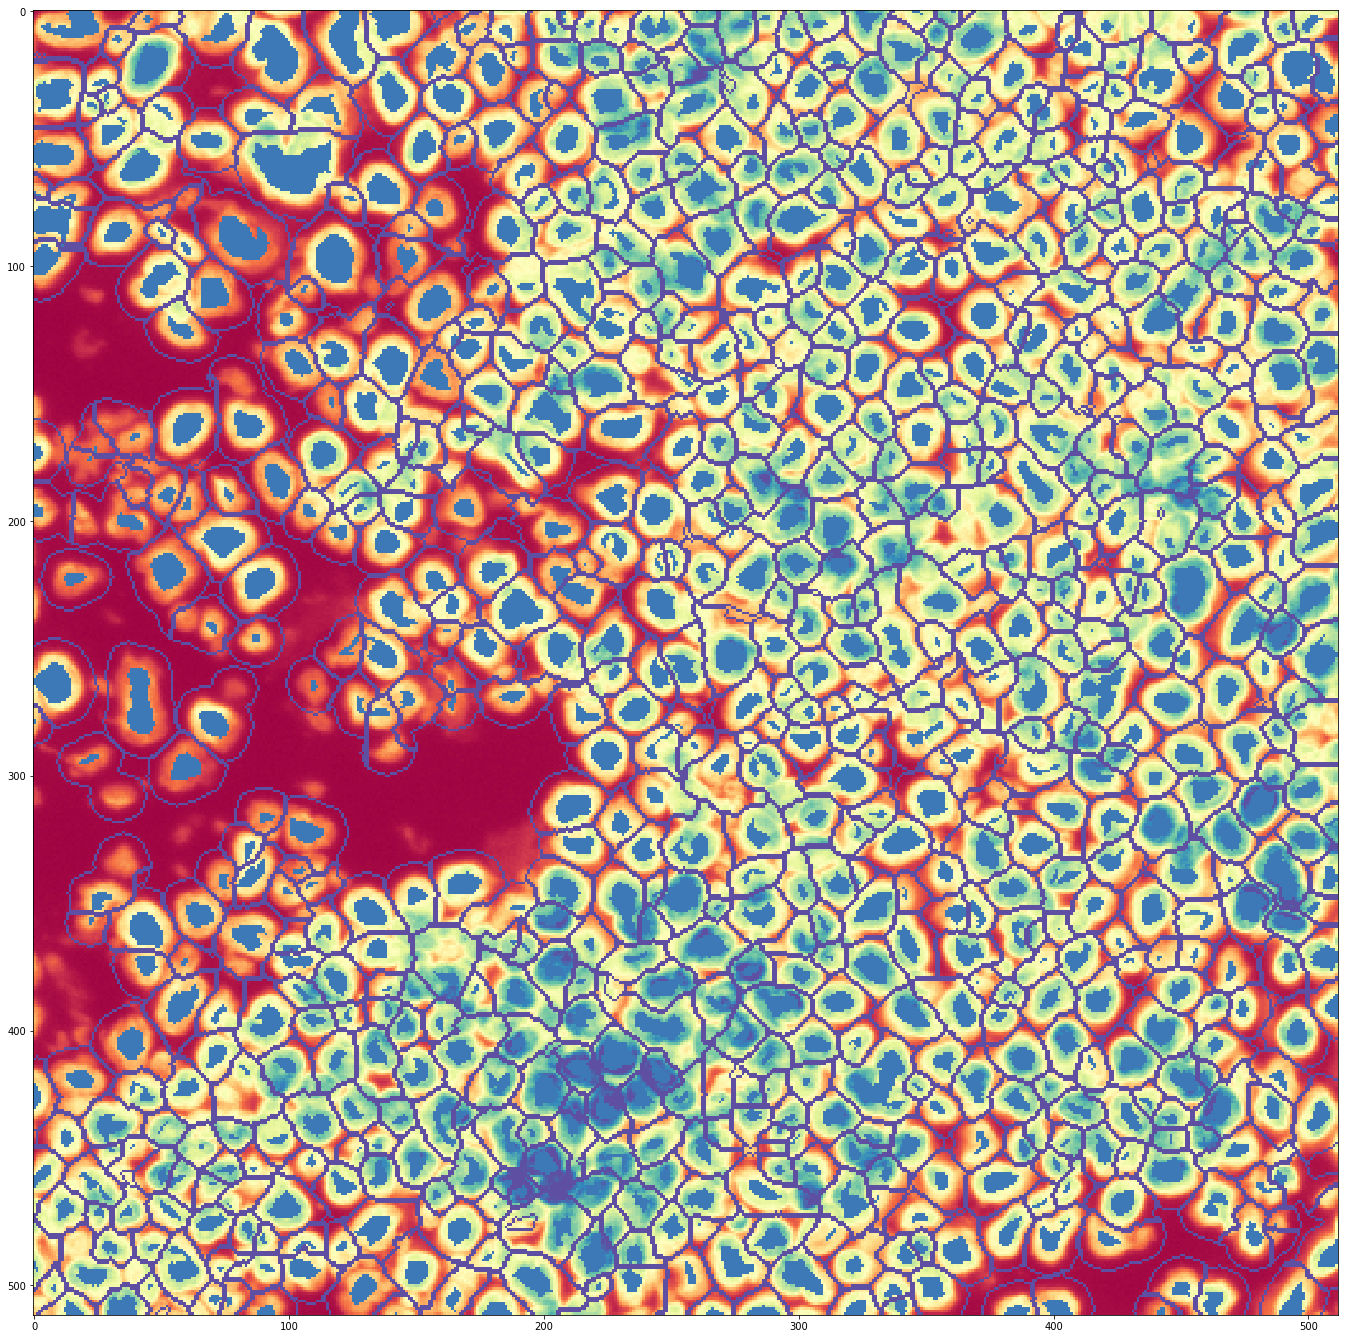

In [32]:
#crop = [slice(0, 256), slice(0, 256)]
#crop = [slice(0, 512), slice(0, 512)]
crop = [slice(0, None), slice(0, None)]
plt.imshow(img_nuc_border[crop], cmap='Spectral')
plt.gcf().set_size_inches(24, 24)

In [26]:
# crop = [slice(0, 500), slice(0, 500)]
# visualize.display_images([
#     img_seg_border[crop], 
#     img_nuc_border[crop],
#     img_mem_border[crop],
#     seg_mask[crop]
# ], size=25, cmap='jet', cols=2)

In [177]:
img_com = np.zeros_like(img_nuc)
props = measure.regionprops(img_bin_nuc_label, intensity_image=img_nuc)
for prop in props:
    r, c = prop.weighted_centroid
    rr, cc = draw.circle(int(r), int(c), radius=2, shape=img_com.shape)
    img_com[rr, cc] = 1
img_com = morphology.label(img_com)